In [1]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from pdpbox import pdp

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

os.chdir(r'D:\L3\L3_SZ_CityScope\backend')


# Constant

In [2]:
pba_to_lbcs={
        1: '9000',
        2: '2300',
        4: '3100',
        5: '3100',
        6: '2500',
        7: '4200',
        8: '4500',
        11: '3100',
        12: '6600',
        13: '6600',
        14: '4100',
        15: '2200',
        16: '4500',
        17: '4500',
        18: '1200',
        23: '2100',
        24: '2100',
        25: '2100',
        26: '4300', 
        91: '9000'
        }

# Data

In [3]:
dpath = 'cities/shenzhen/raw/building_energy/2012_public_use_data_aug2016.csv'
data = pd.read_csv(dpath)
data.head()

,PUBID,REGION,CENDIV,PBA,FREESTN,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,RFTILT,BLDSHP,GLSSPC,EQGLSS,SUNGLS,NFLOOR,BASEMNT,FLCEILHT,ATTIC,ELEVTR,NELVTR,ESCLTR,NESLTR,YRCON,YRCONC,MONCON,RENOV,RENADD,RENRDC,RENCOS,RENINT,RENRFF,RENWLL,RENWIN,RENHVC,RENLGT,RENPLB,RENELC,RENINS,RENSAF,RENSTR,RENOTH,ONEACT,ACT1,ACT2,ACT3,ACT1PCT,ACT2PCT,ACT3PCT,PBAPLUS,DRYCL,VACANT,CUBE,CUBEC,CUBELOC,RWSEAT,PBSEAT,EDSEAT,FDSEAT,HCBED,NRSBED,LODGRM,COURT,FACIL,FEDFAC,FACACT,MANIND,PLANT,FACDST,FACDHW,FACDCW,FACELC,BLDPLT,GOVOWN,GOVTYP,OWNTYPE,NOCC,NOCCAT,OWNOCC,OWNOPR,OWNPPR,NWNPPR,NWNOPR,WHOPPR,MONUSE,OCCUPYP,LODOCCP,OPEN24,OPNMF,OPNWE,WKHRS,WKHRSC,NWKER,NWKERC,HT1,HT2,COOL,WATR,COOK,MANU,CAPGEN,GENR,ANYEGY,ELUSED,NGUSED,FKUSED,FKTYPE,PRUSED,STUSED,HWUSED,CWUSED,WOUSED,COUSED,SOUSED,OTUSED,ELHT1,NGHT1,FKHT1,PRHT1,STHT1,HWHT1,WOHT1,COHT1,SOHT1,OTHT1,ELHT2,NGHT2,FKHT2,PRHT2,STHT2,HWHT2,WOHT2,COHT2,SOHT2,OTHT2,HEATP,HTLS50,FURNAC,PKGHT,BOILER,STHW,HTPMPH,SLFCON,OTHTEQ,FURNP,PKGHP,BOILP,STHWP,HTPHP,SLFCNP,OTHTP,MAINHT,NWMNHT,PKGHTTYP,PKGFURN,PKGHTP,PKGCOIL,PKGPIU,PKGDUCT,BLRRAD,BLRFNCL,BLRINDC,BLRLOOP,BLRAIR,BLRPKG,BLRDUCT,DHRAD,DHFNCL,DHINDC,DHLOOP,DHAIR,DHPKG,DHDUCT,HPHPKG,HPHSPLT,HPHROOM,HPHMINI,HPHVRF,HPHAIR,HPHGRD,HPHDUAL,HPHWTR,HPHBKUP,SHRDNT,SHBBRD,SHPORT,SHWALL,SHFURN,SHUNIT,SHPTAC,OTSTRP,OTDUCT,OTPIU,HTVCAV,HTVVAV,HTVFLR,HTVOAS,HTVDEM,HTVNON,ELCOOL,NGCOOL,FKCOOL,PRCOOL,STCOOL,HWCOOL,CWCOOL,OTCOOL,COOLP,RCAC,PKGCL,CHILLR,CHWT,HTPMPC,ACWNWL,EVAPCL,OTCLEQ,RCACP,PKGCP,CHILP,CHWTP,HTPCP,ACWNWP,EVAPP,OTCLP,MAINCL,NWMNCL,PKGCLTYP,CHLAIRCL,CHLWTRCL,CHLABSRP,HTRCHLR,CHLAIR,CHLFNCL,CHLINDC,CHLLOOP,CHLBEAM,CHLPKG,CHLDUCT,DCWAIR,DCWFNCL,DCWINDC,DCWLOOP,DCWBEAM,DCWPKG,DCWDUCT,HPCPKG,HPCSPLT,HPCROOM,HPCMINI,HPCVRF,HPCAIR,HPCGRD,HPCDUAL,HPCWTR,CLVCAV,CLVVAV,CLVFLR,CLVOAS,CLVDEM,CLVNON,EMCS,RDHTNF,HWRDHT,RDCLNF,HWRDCL,ECN,ECNTYPE,MAINT,ELWATR,NGWATR,FKWATR,PRWATR,STWATR,HWWATR,WOWATR,COWATR,SOWATR,OTWATR,WTHTEQ,BOOSTWT,INSTWT,ELCOOK,NGCOOK,FKCOOK,PRCOOK,STCOOK,HWCOOK,WOCOOK,COCOOK,SOCOOK,OTCOOK,ELMANU,NGMANU,FKMANU,PRMANU,STMANU,HWMANU,WOMANU,COMANU,SOMANU,OTMANU,NGGENR,FKGENR,PRGENR,WOGENR,COGENR,SOGENR,OTGENR,PVC,FUELCL,LRGTRB,MCROTB,ENGINE,GENUSE,COGEN,TOGRID,NGOTH,FKOTH,PROTH,STOTH,HWOTH,CWOTH,WOOTH,COOTH,SOOTH,OTOTH,ELLOCUT,ELNONLU,ELOTSRC,ELCPLT,ELLUPCT,NGSRC,PRAMTC,PRUNIT,WOAMT,WOSRC,WOEXP,WOEXPC,AMIMETER,ENRGYPLN,SNACK,FASTFD,CAF,FDPREP,KITCHN,BREAKRM,OTFDRM,HWTRM,LAUNDR,CONFSP,CONFSPP,MEDEQP,XRAYN,CTSCAN,MRI,LINACC,OUTSURG,LABEQP,MCHEQP,POOL,HTPOOL,POOLSRC,STRLZR,RFGEQP,RFGRES,RFGCOMP,RFGWI,RFGOP,RFGCL,RFGVEN,RFGICE,RFGSTO,RFGRSN,RFGCOMPN,RFGWIN,RFGOPN,RFGCLN,RFGVNN,RFGICN,RFGSTP,WHRECOV,WHHT2,WHWT,WHOT,PCTERM,PCTERMN,PCTRMC,MLTMON,MLTMNC,FLATC,LAPTPN,LAPTPC,PRNTRN,PRNTYP,SERVER,SERVERN,SERVERC,DATACNTR,DCNTRSFC,TRNGRM,STDNRM,WBOARDS,TVVIDEO,TVVIDEON,RGSTR,RGSTRN,COPIER,COPIERN,FAX,LTOHRP,LOHRPC,LTNR24,LTNHRP,LNHRPC,RDLTNF,FLUOR,CFLR,BULB,HALO,HID,LED,OTLT,FLUORP,CFLRP,BULBP,HALOP,HIDP,LEDP,OTLTP,EMCSLT,SCHED,OCSN,DIM,DAYHARV,TRIM,PLGCTRL,DRLGHT,LTEXPC,PKLT,WINTYP,TINT,REFL,AWN,SKYLT,DAYLTP,ZSQFT,ZSQFTC,ZWLCNS,ZRFCNS,ZRFCOOL,ZRFTILT,ZBLDSHP,ZGLSSPC,ZEQGLSS,ZSUNGLS,ZNFLOOR,ZBASEMNT,ZFLCEILHT,ZATTIC,ZELEVTR,ZNELVTR,ZESCLTR,ZNESLTR,ZYRCON,ZYRCONC,ZRENOV,ZRENADD,ZRENRDC,ZRENCOS,ZRENINT,ZRENRFF,ZRENWLL,ZRENWIN,ZRENHVC,ZRENLGT,ZRENPLB,ZRENELC,ZRENINS,ZRENSAF,ZRENSTR,ZRENOTH,ZDRYCL,ZCUBE,ZCUBEC,ZCUBELOC,ZRWSEAT,ZPBSEAT,ZEDSEAT,ZFDSEAT,ZHCBED,ZNRSBED,ZLODGRM,ZFACIL,ZFEDFAC,ZFACACT,ZPLANT,ZFACDST,ZFACDHW,ZFACDCW,ZFACELC,ZBLDPLT,ZGOVOWN,ZGOVTYP,ZOWNTYPE,ZNOCC,ZNOCCAT,ZOWNOCC,ZOWNOPR,ZOWNPPR,ZNWNPPR,ZNWNOPR,ZWHOPPR,ZMONUSE,ZOCCUPYP,ZLODOCCP,ZOPEN24,ZOPNMF,ZOPNWE,ZWKHRS,ZWKHRSC,ZNWKER,ZNWKERC,ZHT1,ZHT2,ZCOOL,ZWATR,ZCOOK,ZMANU,ZCAPGEN,ZGENR,ZELUSED,ZNGUSED,ZFKUSED,ZPRUSED,ZSTUSED,ZHWUSED,ZCWUSED,ZWOUSED,ZCOUSED,ZSOUSED,ZOTUSED,ZELHT1,ZNGHT1,ZFKHT1,ZPRHT1,ZSTHT1,ZHWHT1,ZWOHT1,ZCOHT1,ZSOHT1,ZOTHT1,ZELHT2,ZNGHT2,ZFKHT2,ZPRHT2,ZSTHT2,ZHWHT2,ZWOHT2,ZCOHT2,ZSOHT2,ZOTHT2,ZHEATP,ZHTLS50,ZFURNAC,ZPKGHT,ZBOILER,ZSTHW,ZHTPMPH,ZSLFCON,ZOTHTEQ,ZFURNP,ZPKGHP,ZBOILP,ZSTHWP,ZHTPHP,ZSLFCN

## Data Preparing

In [4]:
data.loc[data['NFLOOR']==994, 'NFLOOR']=20
data.loc[data['NFLOOR']==995, 'NFLOOR']=30
# data['AGE'] = data.apply(lambda row: row['YRCONC'], axis=1)
data['LBCS'] = data.apply(lambda row: pba_to_lbcs[row['PBA']], axis=1)
data['SQM'] = 0.092 * data['SQFT']

numerical_regressors = ['NFLOOR','NWKER', 'SQM']
categorical_regressors = ['LBCS']
target = 'MFBTU'

data = data[numerical_regressors + categorical_regressors + [target]]
data = data.loc[~data[target].isnull()]

features = numerical_regressors.copy()
for cat_reg in categorical_regressors:
    new_dummies = pd.get_dummies(data[cat_reg], prefix=cat_reg, drop_first=True)
    data = pd.concat([data, new_dummies], axis=1)
    features += new_dummies.columns.tolist()

In [5]:
X = np.array(data[features])
y = np.array(data[target])
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)

In [6]:
data.head()

,NFLOOR,NWKER,SQM,LBCS,MFBTU,LBCS_2100,LBCS_2200,LBCS_2300,LBCS_2500,LBCS_3100,LBCS_4100,LBCS_4200,LBCS_4300,LBCS_4500,LBCS_6600,LBCS_9000
0,1,2,220.8,4300,26934.0,0,0,0,0,0,0,0,1,0,0,0
1,1,52,10488.0,2100,5889672.0,1,0,0,0,0,0,0,0,0,0,0
2,1,10,234.6,2200,38893.0,0,1,0,0,0,0,0,0,0,0,0
3,20,165,46000.0,1200,48437214.0,0,0,0,0,0,0,0,0,0,0,0
4,2,19,2760.0,2300,1916844.0,0,0,1,0,0,0,0,0,0,0,0


In [7]:
print('Traning data shape: ', X_train.shape)
print('Traning target shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test target shape: ', y_test.shape)

Traning data shape:  (5243, 14)
Traning target shape:  (5243,)
Test data shape:  (1311, 14)
Test target shape:  (1311,)


# Linear Regression

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

equation = '{} = {:4.4f}'.format(target, lr.intercept_)
for fea_name, coeff in zip(features, lr.coef_):
    if coeff > 0:
        this_str = ' + {:4.2f} * {}'.format(coeff, fea_name)
    else:
        this_str = ' - {:4.2f} * {}'.format(-coeff, fea_name)
    equation += this_str
print(f'Linear Regerssion Equation:\n{equation}')
        

Linear Regerssion Equation:
MFBTU = 3910682.5601 - 1054945.57 * NFLOOR + 44367.13 * NWKER + 1083.87 * SQM - 7593635.30 * LBCS_2100 - 1814031.95 * LBCS_2200 - 14793479.09 * LBCS_2300 - 1803405.60 * LBCS_2500 - 10981997.59 * LBCS_3100 - 6768941.02 * LBCS_4100 - 3330288.52 * LBCS_4200 - 3809582.07 * LBCS_4300 + 22688407.51 * LBCS_4500 + 574254.84 * LBCS_6600 + 1631175.73 * LBCS_9000


Training:
MSE=1670413717418636.0000, Median AE=5219675.6758, r2=0.5814

Test:
MSE=876065140176151.8750, Median AE=4964890.7644, r2=0.6904


(-40150849.6, 843168743.6, -36706397.05358528, 466930602.2885151)

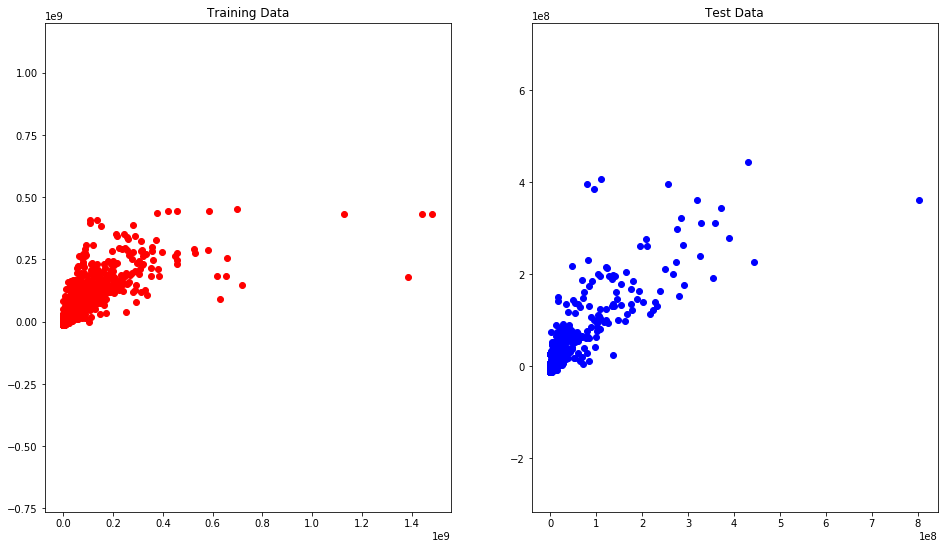

In [9]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)
print('Training:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_train, pred_train), 
    median_absolute_error(y_train, pred_train),
    r2_score(y_train, pred_train)
))
print('\nTest:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_test, pred_test), 
    median_absolute_error(y_test, pred_test),
    r2_score(y_test, pred_test)
))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.plot(y_train, pred_train, 'ro')
ax1.set_title('Training Data')
ax1.axis('equal')
ax2.plot(y_test, pred_test, 'bo')
ax2.set_title('Test Data')
ax2.axis('equal')

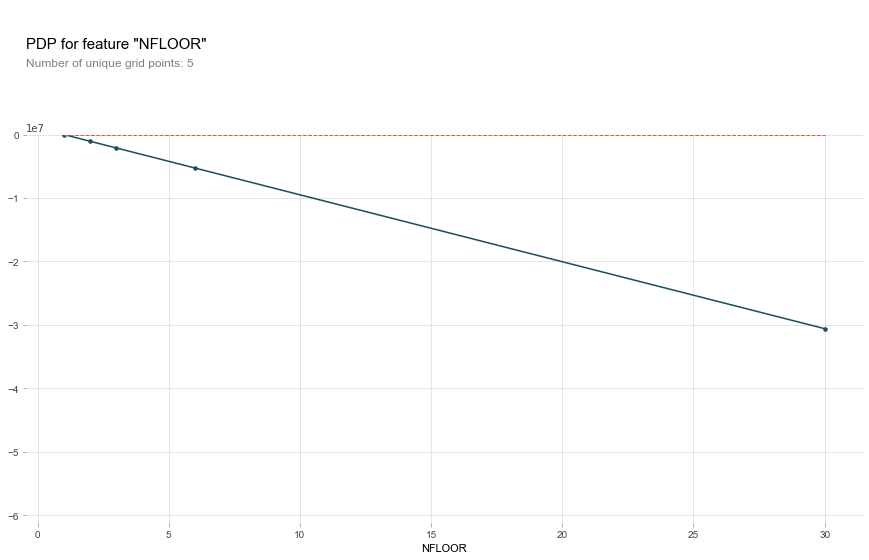

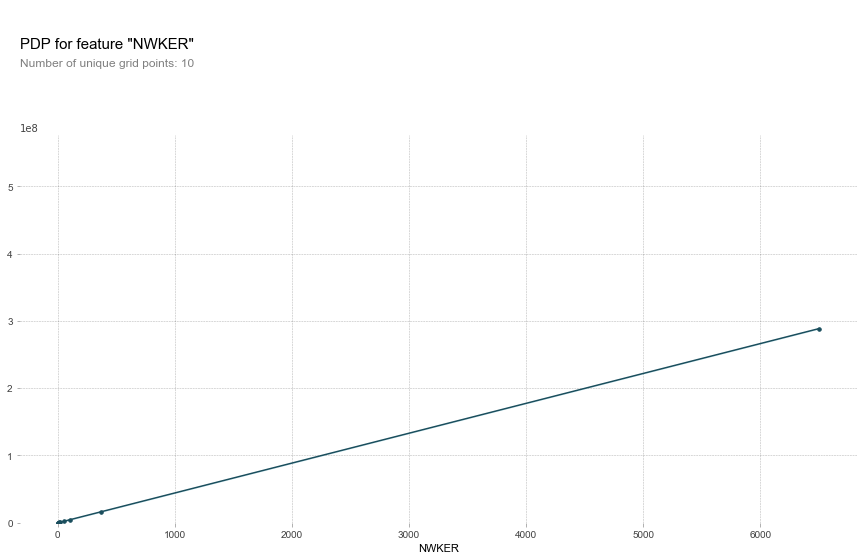

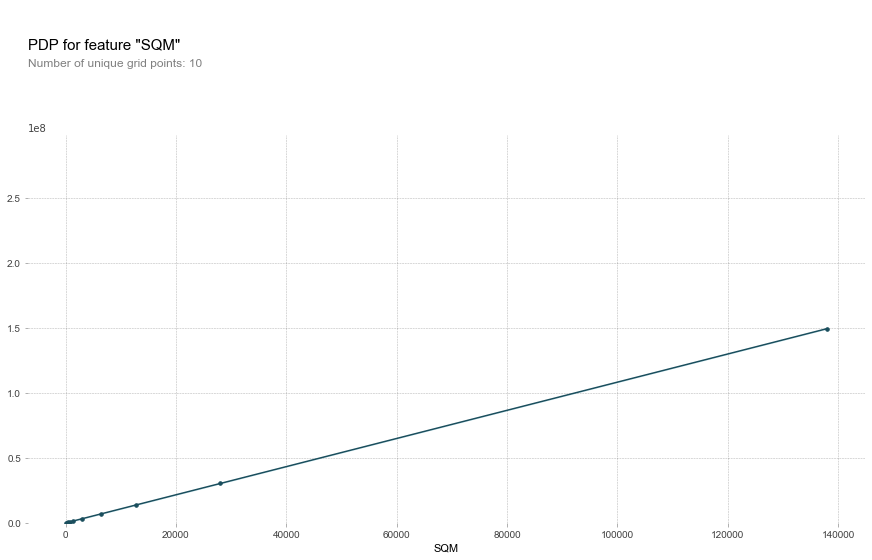

In [10]:
for inspect_feature in ['NFLOOR', 'NWKER', 'SQM']:
    pdp_goals = pdp.pdp_isolate(model=lr, 
                                dataset=data, 
                                model_features=features, 
                                feature=inspect_feature)
    pdp.pdp_plot(pdp_goals, inspect_feature)

# Random Forest Regressor

## Training

In [11]:
rf = RandomForestRegressor(random_state=0, n_estimators=64)    

# Create the parameter ranges
maxDepth = list(range(5,100,5)) # Maximum depth of tree
maxDepth.append(None)
minSamplesSplit = range(2,42,5) # Minimum samples required to split a node
minSamplesLeaf = range(1,101,10) # Minimum samples required at each leaf node
max_features = ['auto', 'sqrt', 'log2']

#Create the grid
randomGrid = {'max_depth': maxDepth,
              'min_samples_split': minSamplesSplit,
              'min_samples_leaf': minSamplesLeaf,
              'max_features': max_features}

# Create the random search object
rfRandom = RandomizedSearchCV(estimator=rf, 
                              param_distributions=randomGrid,
                              n_iter=512, 
                              cv=5, 
                              verbose=1, 
                              random_state=0, 
                              refit=True, 
                              n_jobs=-1)

# Perform the random search and find the best parameter set
rfRandom.fit(X_train, y_train)
rfWinner = rfRandom.best_estimator_
rfBestParams = rfRandom.best_params_

print(f'Best score for random forest: {rfRandom.best_score_}')

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:  5.0min finished


Best score for random forest: 0.6827733694283854


## Feature Importance

Feature ranking:
1. NWKER (0.344540)
2. SQM (0.327002)
3. NFLOOR (0.157237)
4. LBCS_4500 (0.087659)
5. LBCS_2300 (0.041630)
6. LBCS_6600 (0.016707)
7. LBCS_3100 (0.008917)
8. LBCS_9000 (0.007705)
9. LBCS_2100 (0.004569)
10. LBCS_4300 (0.001815)
11. LBCS_4100 (0.001068)
12. LBCS_4200 (0.000800)
13. LBCS_2200 (0.000288)
14. LBCS_2500 (0.000062)


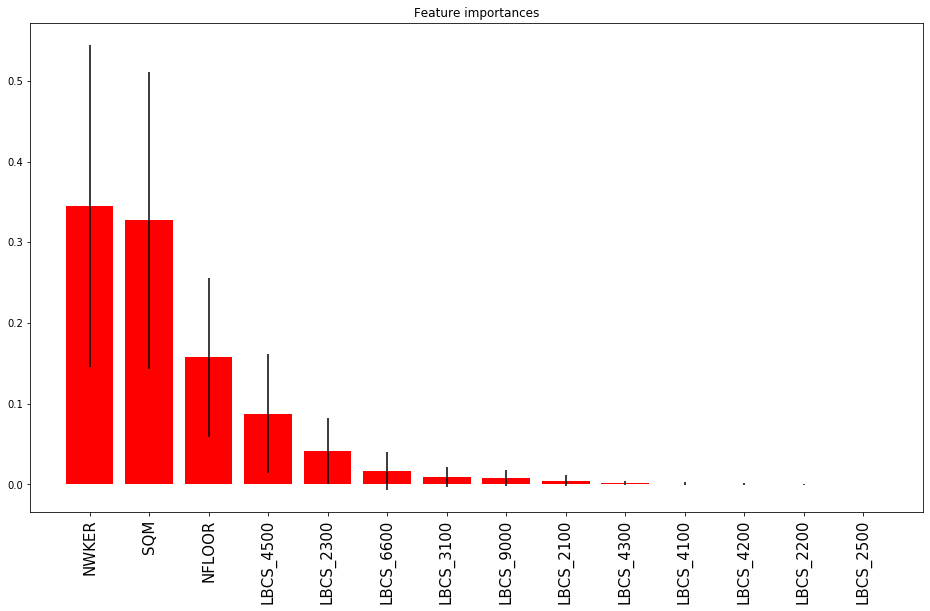

In [12]:
importances = rfWinner.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfWinner.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(features)):
    print("%d. %s (%f)" % (f+1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16, 9))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90, fontsize=15)
plt.xlim([-1, len(features)])
plt.show()

## Prediction Performance

Training:
MSE=572264300085658.0000, Median AE=494693.3391, r2=0.8566

Test:
MSE=553135746782466.0625, Median AE=691509.3560, r2=0.8045


(-40150849.6, 843168743.6, -31483402.745131377, 661821735.3071185)

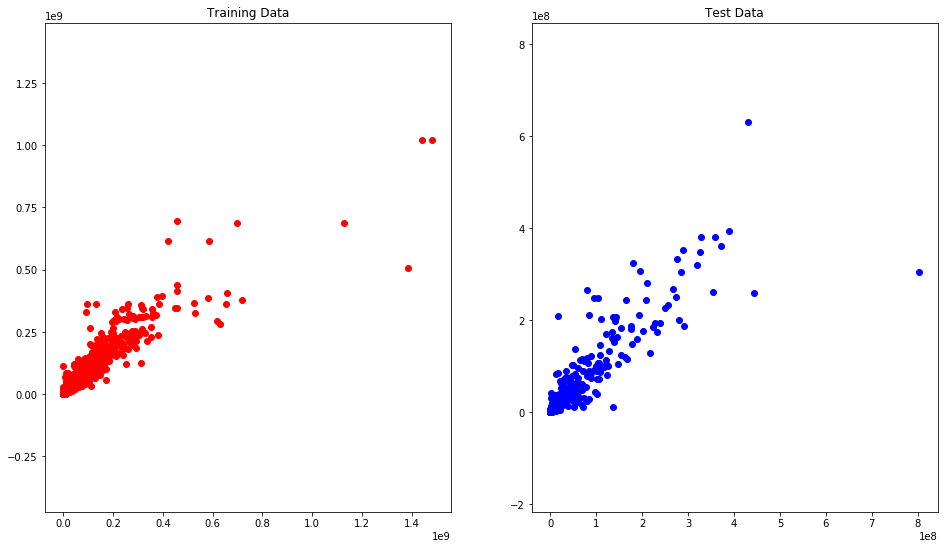

In [13]:
pred_train = rfWinner.predict(X_train)
pred_test = rfWinner.predict(X_test)
print('Training:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_train, pred_train), 
    median_absolute_error(y_train, pred_train),
    r2_score(y_train, pred_train)
))
print('\nTest:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_test, pred_test), 
    median_absolute_error(y_test, pred_test),
    r2_score(y_test, pred_test)
))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.plot(y_train, pred_train, 'ro')
ax1.set_title('Training Data')
ax1.axis('equal')
ax2.plot(y_test, pred_test, 'bo')
ax2.set_title('Test Data')
ax2.axis('equal')

## Partial Dependence Plot

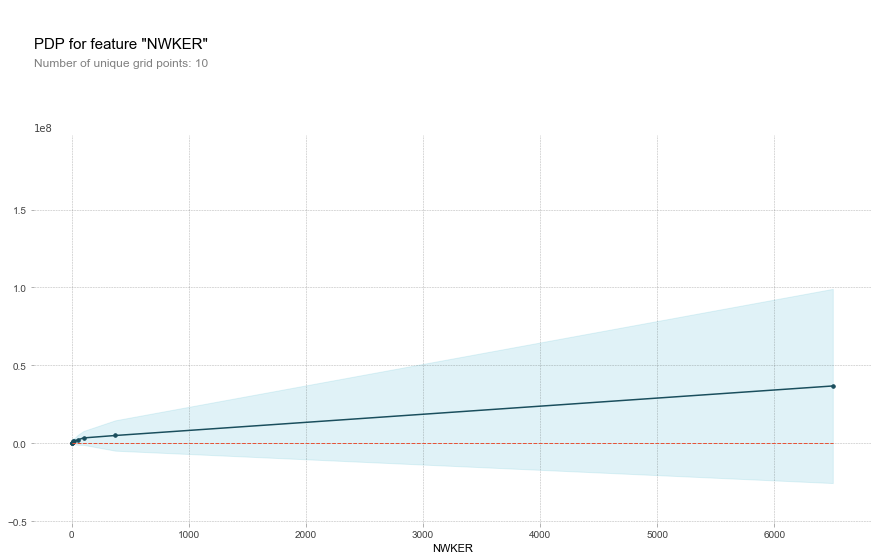

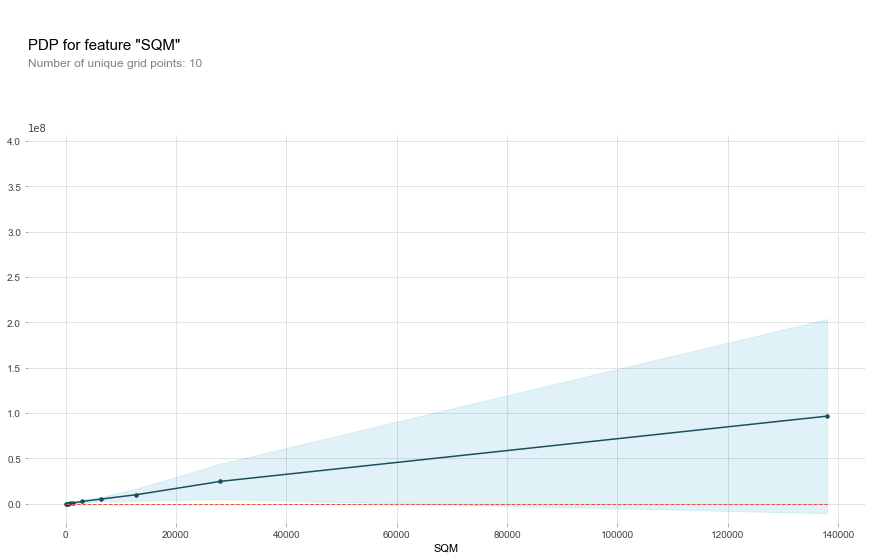

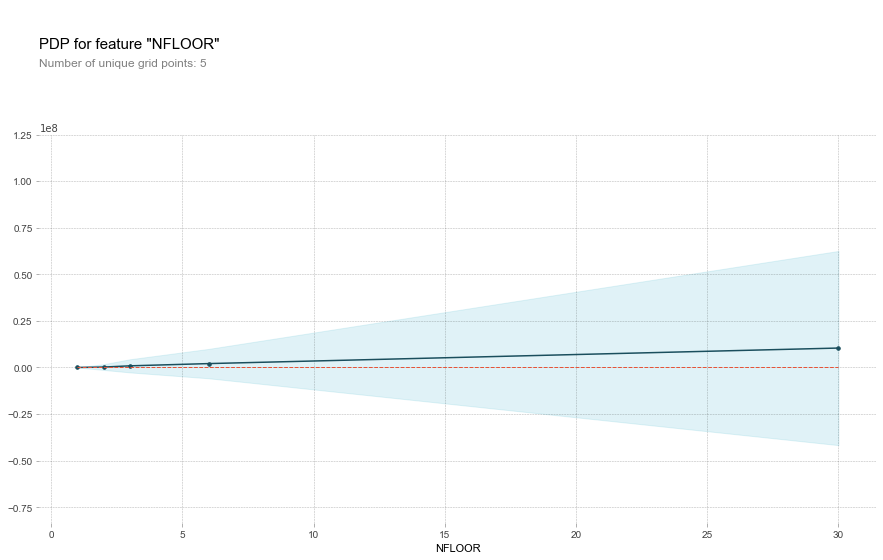

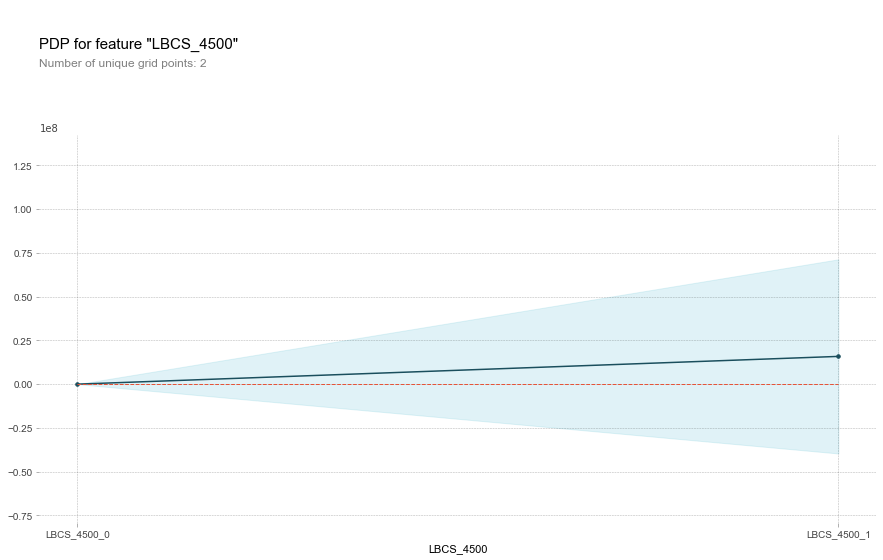

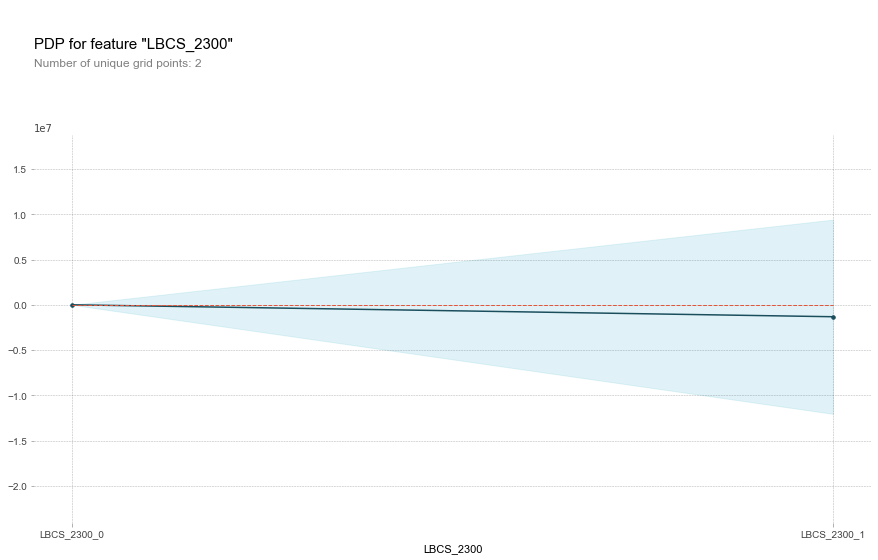

In [14]:
rf.fit(X_train, y_train)
for idx in range(5):
    inspect_feature = features[indices[idx]]
    pdp_goals = pdp.pdp_isolate(model=rf, 
                                dataset=data, 
                                model_features=features, 
                                feature=inspect_feature)
    pdp.pdp_plot(pdp_goals, inspect_feature)
#     plt.show()

## GBDT Regressor

In [15]:
gb = GradientBoostingRegressor(n_estimators=64, random_state=0)

# Create the parameter ranges
maxDepth = list(range(5,100,5)) # Maximum depth of tree
maxDepth.append(None)
minSamplesSplit = range(2,42,5) # Minimum samples required to split a node
minSamplesLeaf = range(1,101,10) # Minimum samples required at each leaf node
max_features = ['auto', 'sqrt', 'log2']
lr = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

#Create the grid
randomGrid = {'max_depth': maxDepth,
              'min_samples_split': minSamplesSplit,
              'min_samples_leaf': minSamplesLeaf, 
              'max_features': max_features,
              'learning_rate': lr}

# Create the random search object
gbRandom = RandomizedSearchCV(estimator=gb, 
                              param_distributions=randomGrid,
                              n_iter=512, 
                              cv = 5, 
                              verbose=1, 
                              random_state=0,
                              refit=True, 
                              n_jobs=-1)

# Perform the random search and find the best parameter set
gbRandom.fit(X_train, y_train)
gbWinner=gbRandom.best_estimator_
gbBestParams=gbRandom.best_params_

# Save
print(f'Best score for GBDT: {gbRandom.best_score_}')

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed: 10.1min finished


Best score for GBDT: 0.6902019975205562


## Partial Dependence Plot

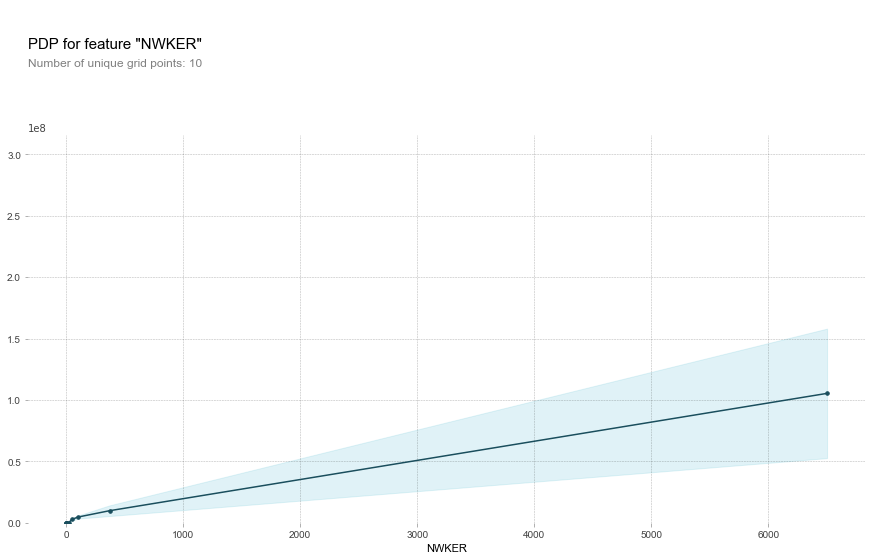

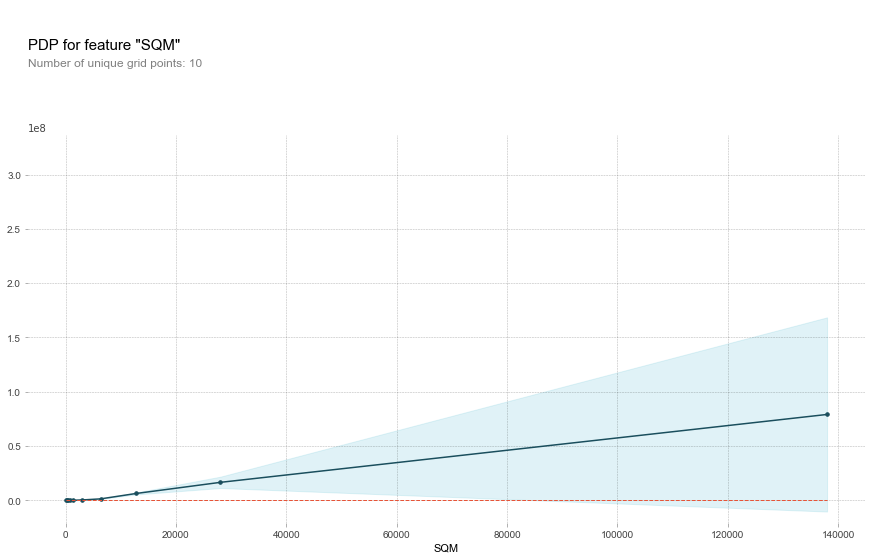

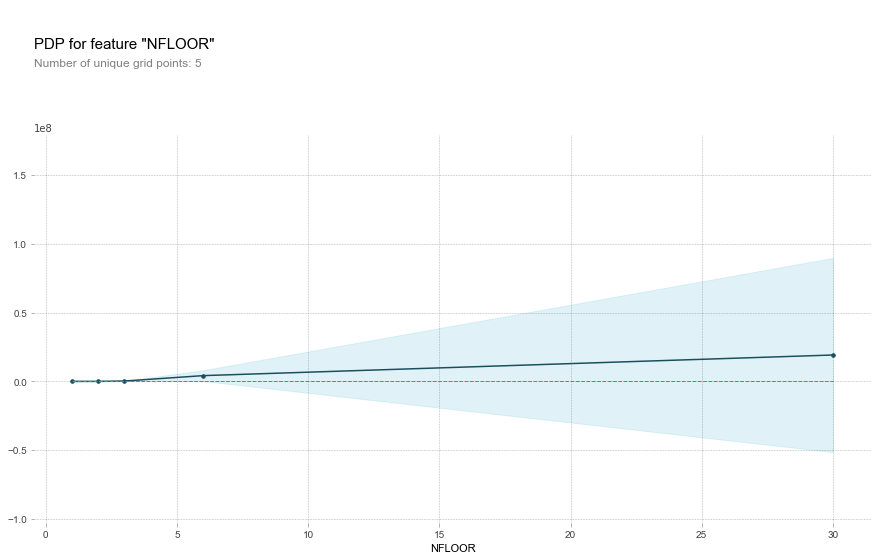

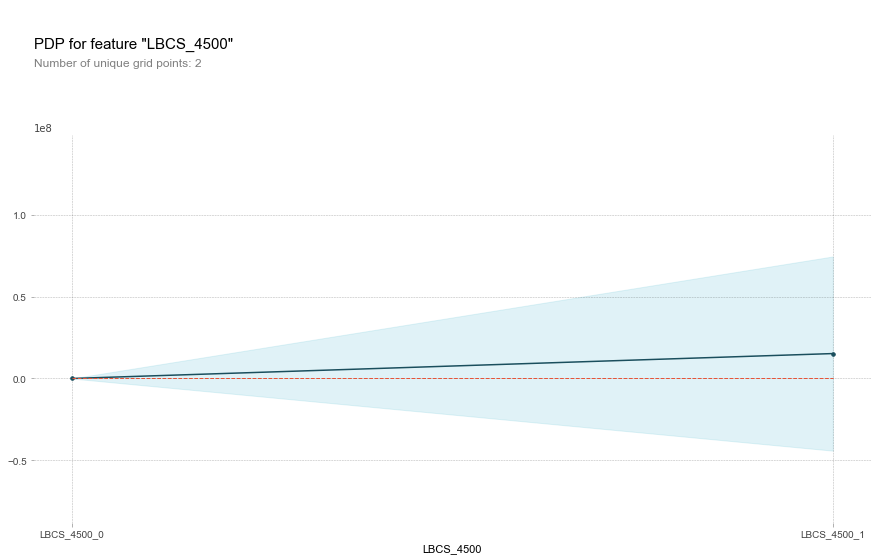

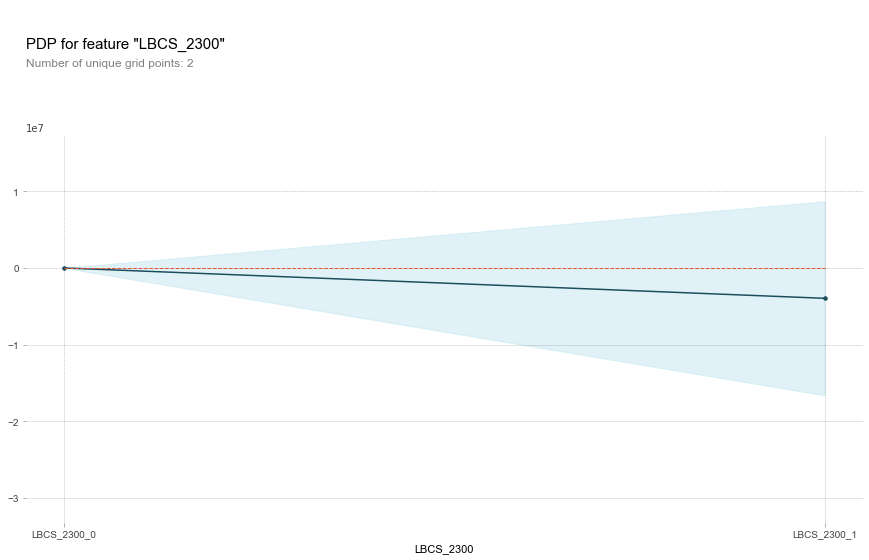

In [19]:
gb.fit(X_train, y_train)
for idx in range(5):
    inspect_feature = features[indices[idx]]
    pdp_goals = pdp.pdp_isolate(model=gb, 
                                dataset=data, 
                                model_features=features, 
                                feature=inspect_feature)
    pdp.pdp_plot(pdp_goals, inspect_feature)
#     plt.show()

## Prediction Performance

Training:
MSE=637568169869452.0000, Median AE=1739830.2830, r2=0.8402

Test:
MSE=548638556650447.0000, Median AE=1741896.1663, r2=0.8061


(-40150849.6, 843168743.6, -30837836.191517822, 664355220.2704024)

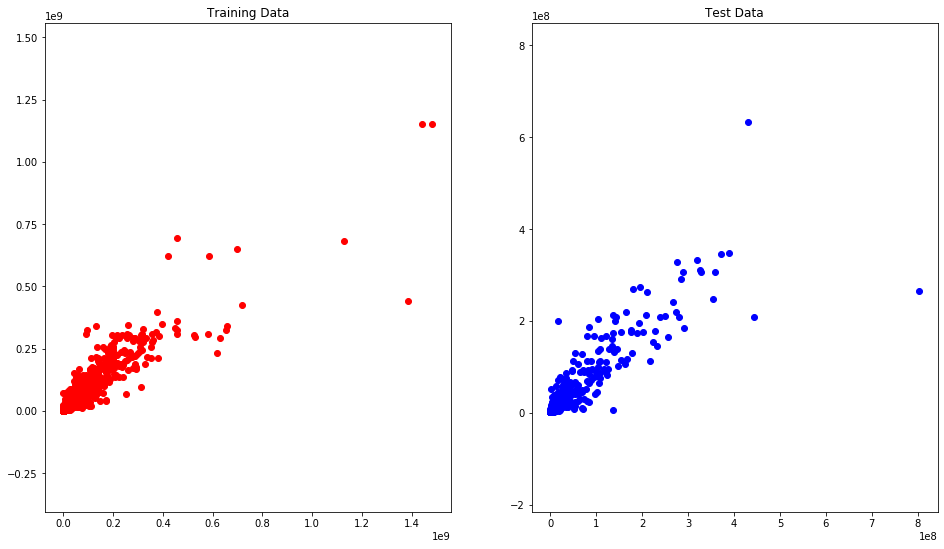

In [16]:
pred_train = gbWinner.predict(X_train)
pred_test = gbWinner.predict(X_test)
print('Training:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_train, pred_train), 
    median_absolute_error(y_train, pred_train),
    r2_score(y_train, pred_train)
))
print('\nTest:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_test, pred_test), 
    median_absolute_error(y_test, pred_test),
    r2_score(y_test, pred_test)
))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.plot(y_train, pred_train, 'ro')
ax1.set_title('Training Data')
ax1.axis('equal')
ax2.plot(y_test, pred_test, 'bo')
ax2.set_title('Test Data')
ax2.axis('equal')

# Residence

In [20]:
res_data = pd.read_csv('cities/shenzhen/raw/building_energy/recs2015_public_v4.csv')
sample_data = res_data.loc[range(10), ['TOTALBTU', 'BTUEL', 'BTUNG', 'BTULP', 'BTUFO']]
sample_data

,TOTALBTU,BTUEL,BTUNG,BTULP,BTUFO
0,48974.570,17983.771,30990.800,0.000,0.000
1,41534.000,41534.000,0.000,0.000,0.000
2,96548.160,67064.204,29483.956,0.000,0.000
3,89284.345,33616.851,0.000,55667.494,0.000
4,36582.146,10630.615,25951.531,0.000,0.000
5,30294.147,9475.000,0.000,20819.147,0.000
6,52661.720,8181.149,44480.571,0.000,0.000
7,131135.088,47395.746,83739.342,0.000,0.000
8,93683.400,35561.312,0.000,0.000,58122.088
9,63141.798,63141.798,0.000,0.000,0.000
